# Analysis of the chains

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from lisatools.sampling.utility import ModifiedHDFBackend
# from getdist import plots, MCSamples
# import getdist
import corner

In [2]:
filename ='null_test_scalar_AAK_snr_150_no_noise_1000000.0_33.76972391607406_0.9_14.0_0.0_T4.0.h5'
back = ModifiedHDFBackend(filename)


In [3]:
chains = back.get_chain()
loglike = back.get_log_prob()


In [4]:
print(chains.shape, loglike.shape)

n = chains.shape[2]
n_dim = chains.shape[-1]

temp =0

(266300, 3, 16, 6) (266300, 3, 16)


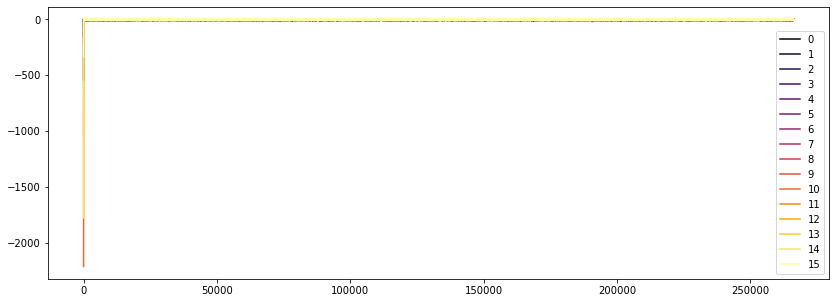

In [5]:
colors = plt.cm.inferno(np.linspace(0,1,n))

var=1
temp =0
plt.figure(figsize=(14,5))

for i in range(0,n):
    plt.plot(loglike[:,temp,i],label=str(i),color=colors[i])

plt.legend()
plt.show()




0 -2.595711066411641
1 -2.619002186594637
2 -2.6045731460178687
3 -2.608164021560111
4 -2.6018360116840866
5 -2.603179535389137
6 -2.603231947889907
7 -2.6214052085452666
8 -2.6141175772242913
9 -2.6084099935470717
10 -2.6212113456112154
11 -2.6046132884755395
12 -2.6169957236639574
13 -2.6054577036967834
14 -2.6123823793700622
15 -2.609947774383012


/data/lsperi/miniconda3/envs/mig_env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


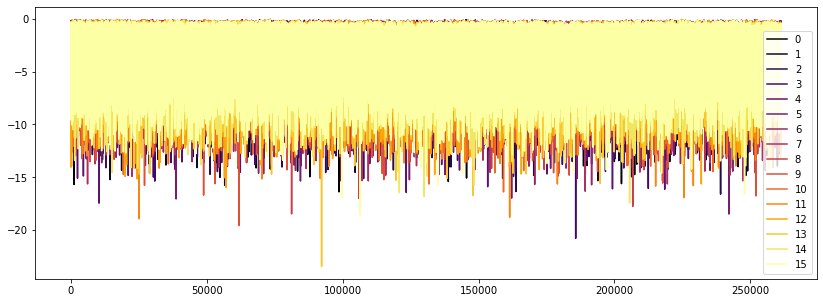

In [6]:
burnin = 5000
# select chains
good_chains = []
for i in range(0,n):
    if np.mean(loglike[burnin:,temp,i])>-100.0:
        print(i, np.mean(loglike[burnin:,temp,i]))
        good_chains.append(i)


plt.figure(figsize=(14,5))

for i in good_chains:
    plt.plot(loglike[burnin:,temp,i],label=str(i),color=colors[i])

plt.legend()
plt.show()

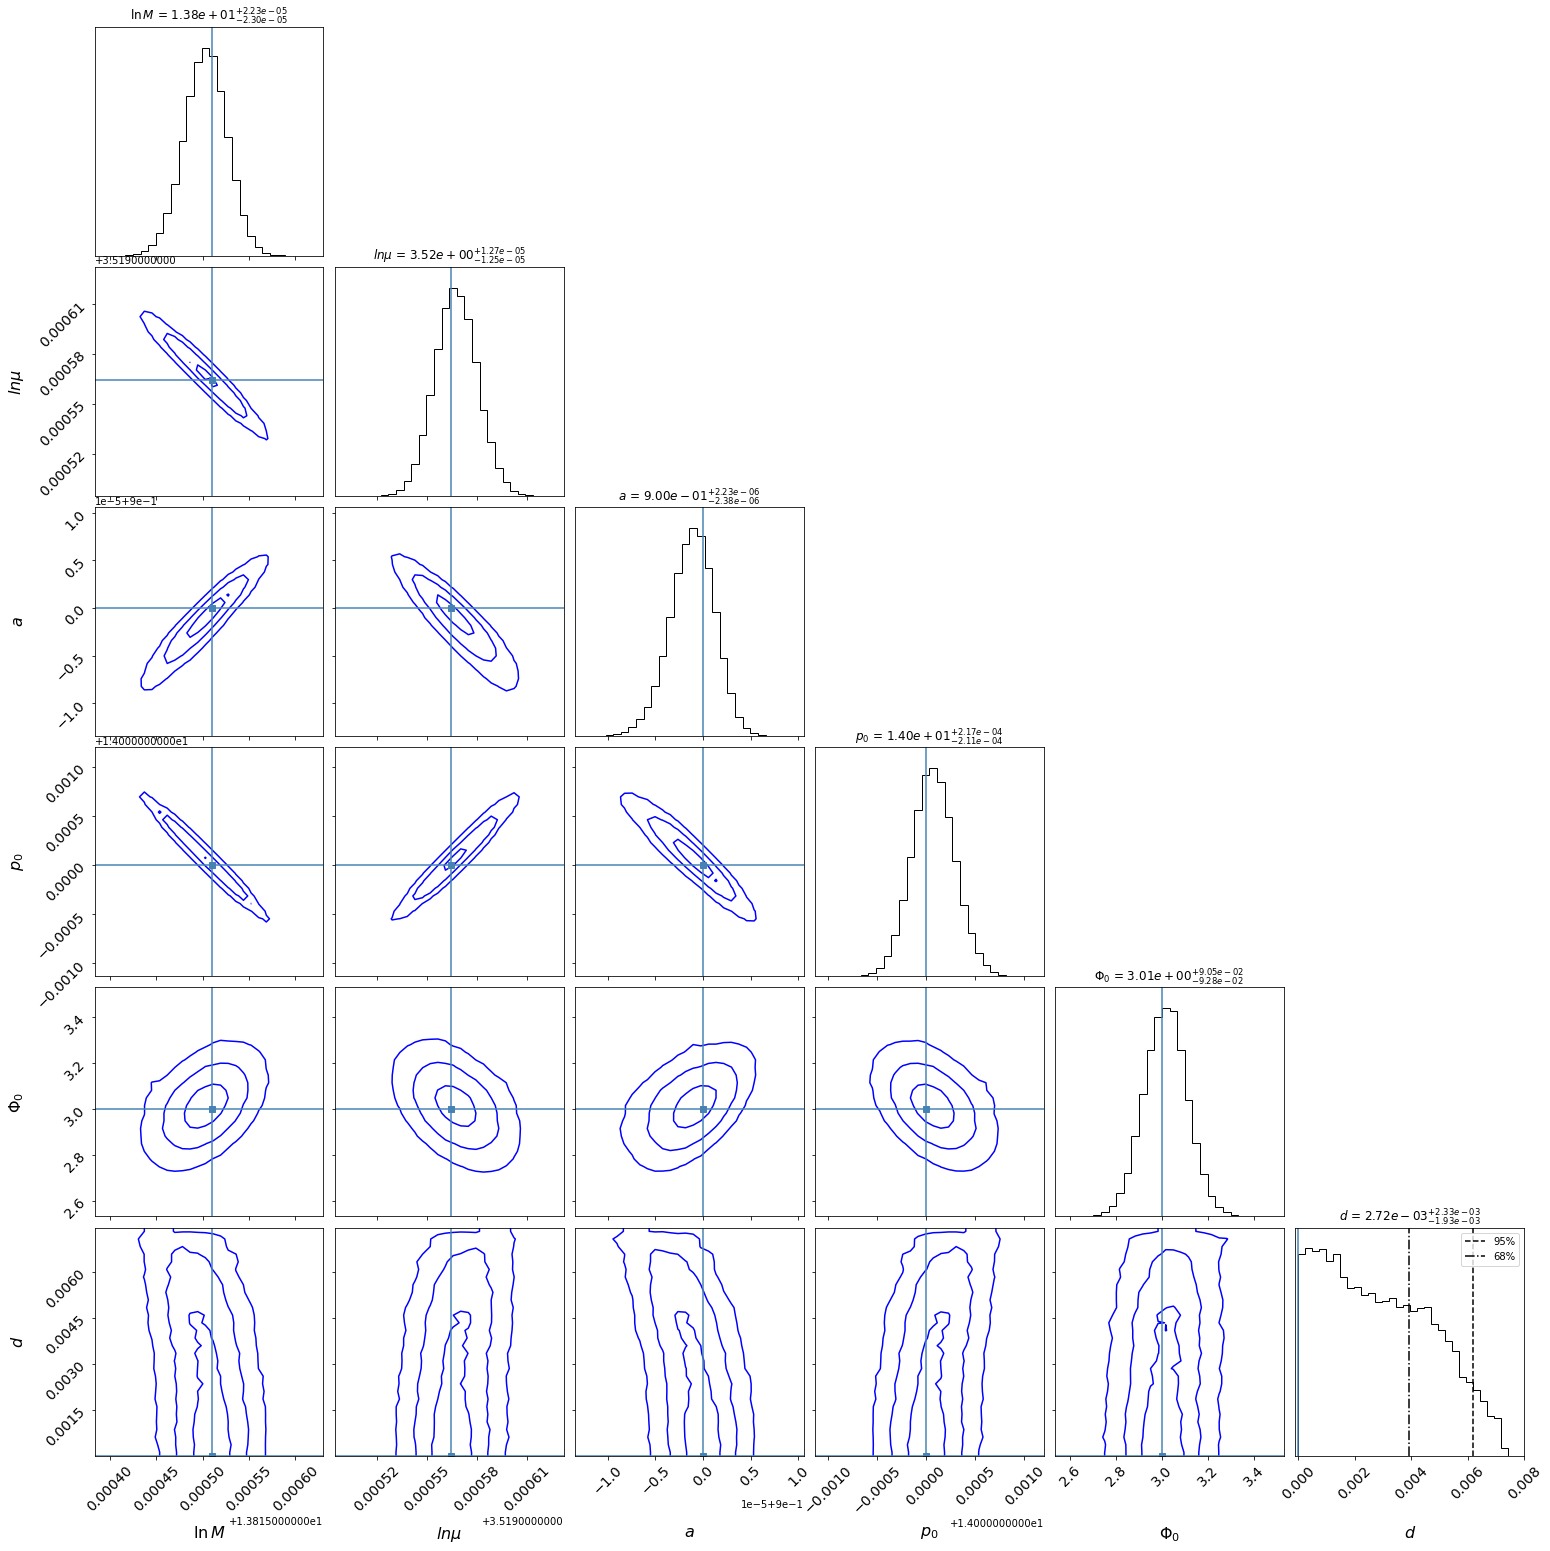

In [30]:
samp = np.array([chains[burnin:,0,good_chains,variable].flatten() for variable in range(n_dim)]).T

inj =[np.log(1000000.0),np.log(33.76972391607406),0.9,14.0,3.0,0.0]

labels = [
    r"$\ln M$",
    r"$ln\mu$",
    r"$a$",
    r"$p_0$",
   r"$\Phi_0$",
    r"$d$",
    ]

corner_kwargs=dict(labels=labels,
            levels=(1 - np.exp(-0.5 * np.array([1, 2, 3]) ** 2)),
            bins=30,
            plot_density=False,
            plot_datapoints=False,
            smooth=0.4,
            contour_kwargs={"colors": "blue"},
            hist_kwargs={"density": True},
            truths=inj,
            show_titles=True,
            title_fmt=".2e",
            label_kwargs=dict(fontsize=16),
            # quantiles=quantiles
           verbose=True,

)

figure = corner.corner(samp, **corner_kwargs)

for ax in figure.get_axes():
    ax.tick_params(axis='both', labelsize=14)
# last plot
ax.set_xlim([-1e-4, 8e-3])
ax.axvline(np.quantile(samp[:,-1], 0.95), color='k', linestyle='--',label='95%')
ax.axvline(np.quantile(samp[:,-1], 0.68), color='k', linestyle='-.',label='68%')
figure.subplots_adjust(right=1.5,top=1.5)
plt.legend(loc='upper right')
figure.savefig('null_test_info_snr_150_M1000000.0_mu33.76972391607406_a0.9_p14.0_d0.0_T4.0.pdf',dpi=300,pad_inches=0.3,bbox_inches='tight')

In [8]:
samp.shape

(4180800, 6)

In [9]:
# save to txt
name_txt ='lnmu_charge_info_snr_150_M1000000.0_mu33.76972391607406_a0.9_p14.0_d0.0_T4.0.dat' 
with open(name_txt, 'w') as f:
    for i in range(samp.shape[0]):
        f.write(str(samp[i,1]) + '\t' + str(samp[i,-1]) + '\n')

In [15]:
# np.save("lnM_lnmu_a_p0_phi0_ScalCharge",samp)

In [10]:
(inj - np.median(samp, axis=0))/np.std(samp, axis=0)

array([-2.47625343,  0.15672218, -3.62521472,  2.51230165,  0.61474121])

In [17]:
nwalkers = len(good_chains)
for variable in range(n_dim):
    # plt.figure()
    # plt.title('Check chains')
    # for i in good_chains:
    #     plt.plot(chains[burnin:,i,variable], label=str(i))

    # #plt.axhline(injection_params[variable] ,label='true',linestyle='--')
    # plt.legend()
    # plt.show()

    N = len(chains[burnin:,temp,good_chains,variable])
    # Gelman-Rubin statistic
    W = 1/nwalkers * np.sum([ np.var(chains[burnin:,temp,j,variable]) for j in good_chains])
    theta_bar_bar = np.mean([ np.mean(chains[burnin:,temp,j,variable]) for j in good_chains])
    B = N/(nwalkers-1) *  np.sum([(np.mean(chains[burnin:,temp,j,variable]) - theta_bar_bar)**2 for j in good_chains])
    Var = (1-1/N)*W + B/N
    R = np.sqrt(Var/W)
    print('Gelman-Rubin statistic', R, ' for variable ', variable)

Gelman-Rubin statistic 1.0000060712967558  for variable  0
Gelman-Rubin statistic 1.0000068737579695  for variable  1
Gelman-Rubin statistic 1.0000051081425383  for variable  2
Gelman-Rubin statistic 1.0000060085139808  for variable  3
Gelman-Rubin statistic 1.0000079896934166  for variable  4
Gelman-Rubin statistic 1.000005762154635  for variable  5


0.006210892493945984

In [12]:
covariance = np.cov(samp.T)


In [14]:
np.save("cov_null_test", covariance)

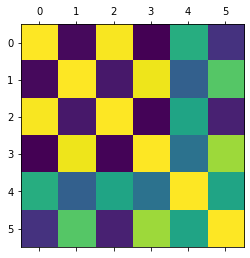

In [13]:
plt.matshow(np.corrcoef(samp.T) )